In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.stats import rankdata

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import rankdata

In [2]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

In [ ]:
class TextFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, swear_list=None):
        self.swear_list = swear_list

    def fit(self, X, y=None):
        if self.swear_list is None:
            self.swear_list_ = {"fuck", "shit", "bitch", "damn", "ass", "crap", "dick"}
        else:
            self.swear_list_ = set(self.swear_list)
        return self

    def transform(self, X):
        features = pd.DataFrame()
        features["text_length"] = X.apply(len)
        features["word_count"] = X.apply(lambda x: len(x.split()))
        punctuations = "!?.,;:"
        features["punct_count"] = X.apply(lambda x: sum(1 for char in x if char in punctuations))
        features["uppercase_ratio"] = X.apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))
        features["swear_word_count"] = X.apply(
            lambda x: sum(1 for word in x.lower().split() if word in self.swear_list_)
        )
        return features.values


In [4]:
train_df = pd.read_csv("/kaggle/input/train-ranking/train.csv")
val_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv")

# Clean text
train_df["clean_text"] = train_df["comment_text"].apply(clean_text)
val_less = val_df["less_toxic"].apply(clean_text)
val_more = val_df["more_toxic"].apply(clean_text)
val_comments = pd.concat([val_less, val_more]).unique()
train_df = train_df[~train_df["clean_text"].isin(val_comments)]


In [5]:
# Create severity scores
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
weights = [.32, 1.82, .16, 1.5, .64, 1.5]
train_df["severity"] = train_df[label_cols].dot(weights)

# Balance the dataset
toxic_df = train_df[train_df["severity"] > 0]
non_toxic_df = train_df[train_df["severity"] == 0].sample(n=len(toxic_df), random_state=42)
balanced_df = pd.concat([toxic_df, non_toxic_df]).sample(frac=1.0, random_state=42).reset_index(drop=True)

Balanced Training Severity Statistics:
count    25460.000000
mean         0.518731
std          0.859296
min          0.000000
25%          0.000000
50%          0.080000
75%          0.800000
max          5.940000
Name: severity, dtype: float64


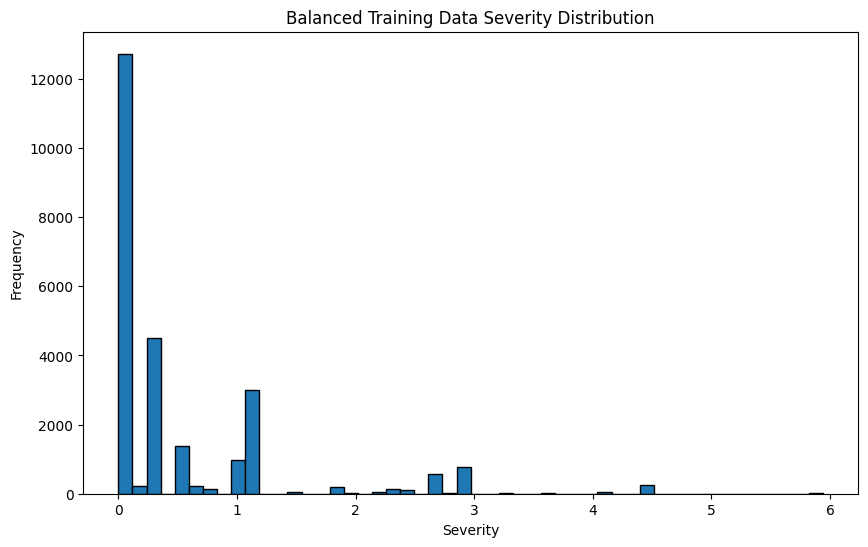

In [ ]:
# severity distribution
print("Balanced Training Severity Statistics:")
print(balanced_df["severity"].describe())
plt.figure(figsize=(10,6))
plt.hist(balanced_df["severity"], bins=50, edgecolor='k')
plt.xlabel("Severity")
plt.ylabel("Frequency")
plt.title("Balanced Training Data Severity Distribution")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Build pipeline
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
combined_features = FeatureUnion([
    ("tfidf", tfidf),
    ("extra_features", TextFeatures())
])
pipeline = Pipeline([
    ("features", combined_features),
    ("ridge", Ridge(solver='lsqr', max_iter=5000))
])

# hyperparameter grid
param_grid = {
    'features__tfidf__min_df': [1, 3],
    'features__tfidf__max_df': [0.75, 1.0],
    'features__tfidf__ngram_range': [(1,1), (1,2)],
    'ridge__alpha': [0.1, 1.0, 10.0],
    'ridge__fit_intercept': [True, False],
}

# simple scoring method for now: R^2 
grid = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3, verbose=2, n_jobs=-1)

# Train on balanced data
X_train = balanced_df["clean_text"]
y_train = balanced_df["severity"]
grid.fit(X_train, y_train)

print("Best Parameters:")
print(grid.best_params_)

# Replace pipeline with the best model
pipeline = grid.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters:
{'features__tfidf__max_df': 0.75, 'features__tfidf__min_df': 3, 'features__tfidf__ngram_range': (1, 1), 'ridge__alpha': 1.0, 'ridge__fit_intercept': True}


In [ ]:
from scipy.stats import rankdata

# Predict on test set
test_df = pd.read_csv("/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv")
print(test_df.info())

test_df["clean_text"] = test_df["text"].apply(clean_text)
raw_predictions = pipeline.predict(test_df["clean_text"])

# Convert raw predictions to unique ranks
ranked_scores = rankdata(raw_predictions, method="ordinal")
test_df["score"] = ranked_scores

submission = test_df[["comment_id", "score"]]
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv (with rank-normalized scores)")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB
None
Submission file saved as submission.csv (with rank-normalized scores)


Total predictions: 7537
Unique raw predictions: 7482
Raw Scores Descriptive Statistics:
count    7537.000000
mean        0.554769
std         0.491885
min        -0.066101
25%         0.305133
50%         0.382566
75%         0.546759
max         5.523019
dtype: float64


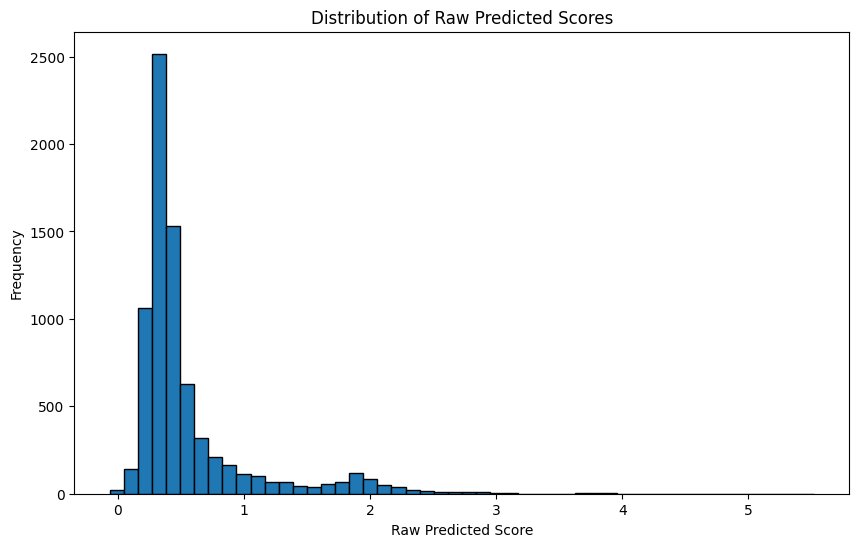

In [9]:
# Score distribution
raw_scores_series = pd.Series(raw_predictions).round(6)
print("Total predictions:", len(raw_scores_series))
print("Unique raw predictions:", raw_scores_series.nunique())
print("Raw Scores Descriptive Statistics:")
print(raw_scores_series.describe())
plt.figure(figsize=(10,6))
plt.hist(raw_scores_series, bins=50, edgecolor='k')
plt.xlabel("Raw Predicted Score")
plt.ylabel("Frequency")
plt.title("Distribution of Raw Predicted Scores")
plt.show()

In [10]:
# Validation agreement
test_map = dict(zip(test_df["clean_text"], test_df["score"]))
val_df["less_toxic_clean"] = val_df["less_toxic"].apply(clean_text)
val_df["more_toxic_clean"] = val_df["more_toxic"].apply(clean_text)

def agree(row):
    a = test_map.get(row["less_toxic_clean"], None)
    b = test_map.get(row["more_toxic_clean"], None)
    if a is None or b is None:
        return None
    return int(a < b)

val_df["agreement"] = val_df.apply(agree, axis=1)
valid_agreement = val_df["agreement"].dropna().mean()
print("Validation agreement accuracy:", valid_agreement)

Validation agreement accuracy: 0.6394582284549922
